# Section 1: Install Required Libraries

This cell installs all the necessary Python packages

In [ ]:
!pip install -q -U transformers accelerate bitsandbytes radon ipywidgets matplotlib

print("✅ All required libraries have been installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.7 MB/s eta 0:00:00
✅ All required libraries have been installed successfully!


# Section 2: Imports and Configuration

In [ ]:
import os
import re
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from radon.visitors import ComplexityVisitor
from radon.metrics import mi_visit
from radon.raw import analyze

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")

# --- Hugging Face Token Setup ---
# Tries to get the token from an environment variable.
# For Google Colab, you can add your HF token to the "Secrets" tab (🔑 icon on the left).
# Name the secret 'HF_TOKEN'.
try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("✅ Hugging Face token loaded from Colab Secrets.")
except (ImportError, KeyError):
    HF_TOKEN = os.getenv('HF_TOKEN')
    if HF_TOKEN:
        print("✅ Hugging Face token loaded successfully from environment variable.")
    else:
        print("🚨 Could not load HF_TOKEN. Please add it to Colab Secrets or set it as an environment variable.")

# --- Model Definitions ---
# A dictionary mapping a user-friendly name to its Hugging Face model ID.
MODELS = {
    "DeepSeek-Coder-1.3B": "deepseek-ai/deepseek-coder-1.3b-instruct",
    "Phi-2-2.7B": "microsoft/phi-2",
    "Stable-Code-3B": "stabilityai/stable-code-3b",
    "Gemma-2B-IT": "google/gemma-2b-it"
}

# --- Caching for Loaded Models ---
# This dictionary will store loaded models and tokenizers to avoid reloading them.
loaded_models_cache = {}

print("✅ Imports and configurations are complete.")

✅ Hugging Face token loaded from Colab Secrets.
✅ Imports and configurations are complete.


# Section 3: Core Functions

This cell contains the main logic for loading models, generating code, and evaluating its quality. No changes are needed here.

In [ ]:
# --- Function to Load Model and Tokenizer ---
def load_model_and_tokenizer(model_name):
    """
    Loads a model and tokenizer from Hugging Face with caching.
    Uses bfloat16 for efficiency and device_map='auto' for GPU utilization.
    """
    model_id = MODELS[model_name]
    if model_id in loaded_models_cache:
        print(f"🧠 Loading {model_name} from cache...")
        return loaded_models_cache[model_id]

    print(f"Downloading and loading {model_name}...")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_id, token=HF_TOKEN, trust_remote_code=True)
        # For Phi-2, pad_token is not set by default. We set it to eos_token.
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            token=HF_TOKEN,
            trust_remote_code=True
        )
        loaded_models_cache[model_id] = (model, tokenizer)
        print(f"✅ {model_name} loaded successfully.")
        return model, tokenizer
    except Exception as e:
        print(f"❌ Error loading {model_name}: {e}")
        return None, None

# --- Function to Generate Code ---
def generate_code(model, tokenizer, prompt):
    """
    Generates code from a given prompt using the specified model and tokenizer.
    """
    print(f"Generating code for prompt: '{prompt[:30]}...'")
    # Gemma and DeepSeek models use a specific chat template for better results.
    if any(model_type in tokenizer.name_or_path for model_type in ["deepseek", "gemma"]):
         messages = [{"role": "user", "content": prompt}]
         input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    else:
        input_text = prompt

    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.2,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id
    )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Use regex to find code within markdown-style code blocks
    code_match = re.search(r"```python\n(.*?)\n```", generated_text, re.DOTALL)
    if code_match:
        return code_match.group(1).strip()

    # A more general regex for any code block
    code_match = re.search(r"```(.*?)```", generated_text, re.DOTALL)
    if code_match:
        # Strip potential language hints like 'python'
        return code_match.group(1).strip().lstrip('python\\n')

    # Fallback if no code block is found: return the text after the input
    return generated_text[len(input_text):].strip()

# --- Function to Evaluate Code Quality ---
def evaluate_code(code_string):
    """
    Analyzes a string of Python code using 'radon' and returns quality metrics.
    """
    if not code_string:
        return {"complexity": 0, "mi_score": 0, "loc": 0}
    try:
        # Use ComplexityVisitor to find functions and their complexity
        visitor = ComplexityVisitor.from_code(code_string)
        total_complexity = sum(f.complexity for f in visitor.functions)

        # Get maintainability index and lines of code
        mi_score = mi_visit(code_string, multi=True)
        raw_analysis = analyze(code_string)
        loc = raw_analysis.lloc # Logical Lines of Code

        return {
            "complexity": total_complexity,
            "mi_score": round(mi_score, 2),
            "loc": loc
        }
    except Exception as e:
        # Handle cases where radon fails to parse the generated code
        print(f"⚠️ Radon analysis failed: {e}")
        return {"complexity": -1, "mi_score": -1, "loc": -1}

print("✅ Core functions defined successfully.")

✅ Core functions defined successfully.


# Section 4: Visualization Function

This cell defines the function for plotting the comparison charts. No changes are needed.

In [ ]:
# This function creates bar charts to compare model performance.

def plot_metrics(results):
    """
    Generates and displays three bar plots for the collected metrics.
    """
    model_names = list(results.keys())
    # Filter out any models where analysis failed
    model_names = [name for name in model_names if results[name]['metrics']['complexity'] != -1]
    if not model_names:
        print("No valid results to plot.")
        return

    complexity_scores = [results[name]['metrics']['complexity'] for name in model_names]
    mi_scores = [results[name]['metrics']['mi_score'] for name in model_names]
    loc_scores = [results[name]['metrics']['loc'] for name in model_names]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Code Generation Model Performance Comparison', fontsize=16)
    colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

    # Plot 1: Cyclomatic Complexity
    ax1.bar(model_names, complexity_scores, color=colors)
    ax1.set_title('Cyclomatic Complexity (Lower is Better)')
    ax1.set_ylabel('Complexity Score')
    ax1.tick_params(axis='x', rotation=45)

    # Plot 2: Maintainability Index
    ax2.bar(model_names, mi_scores, color=colors)
    ax2.set_title('Maintainability Index (Higher is Better)')
    ax2.set_ylabel('MI Score')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(0, 100) # MI score is typically 0-100

    # Plot 3: Logical Lines of Code
    ax3.bar(model_names, loc_scores, color=colors)
    ax3.set_title('Logical Lines of Code (LOC)')
    ax3.set_ylabel('Number of Lines')
    ax3.tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("✅ Visualization function defined successfully.")

✅ Visualization function defined successfully.


# Section 5: Sample Prompts

This cell contains the list of sample prompts for the UIs. No changes are needed.

In [ ]:
# A list of diverse prompts to test the models.

SAMPLE_PROMPTS = [
    # Python / Data Science
    "Write a Python function that takes a pandas DataFrame and returns the correlation matrix for its numeric columns.",
    "Generate a Python script to scrape the headlines from the BBC News homepage using BeautifulSoup.",
    "Create a Python function to implement the bubble sort algorithm.",
    # Web Development
    "Write a simple HTML page with a form that has fields for 'name', 'email' and a 'submit' button.",
    "Generate a JavaScript function that fetches data from an API endpoint and logs the JSON response to the console.",
    # Database
    "Write a SQL query to find all employees who earn more than the average salary of their respective departments.",
    "Write a SQL query to select the top 5 most sold products from a 'sales' table.",
    # General Purpose / DevOps
    "Create a Python function that lists all files in a directory and its subdirectories.",
    "Write a simple Dockerfile for a basic Python Flask application.",
    # Algorithmic
    "Write a Python function to find the factorial of a number using recursion."
]

print(f"✅ {len(SAMPLE_PROMPTS)} sample prompts are ready.")

✅ 10 sample prompts are ready.


# Section 6: Interactive UI #1 (Benchmark All Models)

This UI will now benchmark all models except for the Replit one. No code changes were needed here, as it automatically reads from the updated MODELS dictionary.

In [ ]:
# This UI benchmarks all models defined in the MODELS dictionary for a given prompt.

# --- UI Widgets ---
prompt_input_1 = widgets.Dropdown(
    options=SAMPLE_PROMPTS,
    description='Prompt:',
    style={'description_width': 'initial'},
    layout={'width': '95%'}
)
custom_prompt_input_1 = widgets.Textarea(
    placeholder='Or type your own custom prompt here...',
    layout={'width': '95%', 'height': '80px'}
)
benchmark_button = widgets.Button(description="Benchmark All Models", button_style='success')
output_1 = widgets.Output()

# --- Event Handler ---
def on_benchmark_button_clicked(b):
    with output_1:
        clear_output(wait=True)
        # Use the custom prompt if filled, otherwise use the dropdown value
        prompt = custom_prompt_input_1.value if custom_prompt_input_1.value else prompt_input_1.value
        if not prompt:
            print("🚨 Please select or enter a prompt.")
            return

        print(f"🚀 Starting benchmark for prompt: '{prompt}'\n" + "="*52)
        results = {}
        for model_name in MODELS.keys():
            print(f"--- Processing Model: {model_name} ---")
            model, tokenizer = load_model_and_tokenizer(model_name)
            if model is None: continue

            generated_code = generate_code(model, tokenizer, prompt)
            metrics = evaluate_code(generated_code)
            results[model_name] = {"code": generated_code, "metrics": metrics}

            print(f"\n✨ Generated Code:\n```python\n{generated_code}\n```")
            print(f"\n📊 Metrics: {metrics}")
            print("\n" + "-"*52 + "\n")

        print("📈 Generating performance plots...")
        plot_metrics(results)

benchmark_button.on_click(on_benchmark_button_clicked)

# --- Display UI ---
print("UI #1 is ready. Choose a prompt and click the button to start.")
display(prompt_input_1, custom_prompt_input_1, benchmark_button, output_1)

UI #1 is ready. Choose a prompt and click the button to start.


Dropdown(description='Prompt:', layout=Layout(width='95%'), options=('Write a Python function that takes a pan…

Textarea(value='', layout=Layout(height='80px', width='95%'), placeholder='Or type your own custom prompt here…

Button(button_style='success', description='Benchmark All Models', style=ButtonStyle())

Output()

# Section 7: Interactive UI #2 (Select Models to Inspect)

This UI will now show checkboxes for the updated list of models. No code changes were needed here either.

🚀 Starting inspection for prompt: 'Write a Python function that takes a pandas DataFrame and returns the correlation matrix for its numeric columns.'
Models selected: DeepSeek-Coder-1.3B, Phi-2-2.7B, Stable-Code-3B, Gemma-2B-IT
--- Processing Model: DeepSeek-Coder-1.3B ---
🧠 Loading DeepSeek-Coder-1.3B from cache...
Generating code for prompt: 'Write a Python function that t...'

✨ Generated Code:
```python
import pandas as pd

def correlation_matrix(df):
    return df.corr()
```

📊 Metrics: {'complexity': 1, 'mi_score': 100.0, 'loc': 3}

----------------------------------------------------

--- Processing Model: Phi-2-2.7B ---
🧠 Loading Phi-2-2.7B from cache...
Generating code for prompt: 'Write a Python function that t...'

✨ Generated Code:
```python
import pandas as pd

def correlation_matrix(df):
    return df.corr()

# Example usage
df = pd.read_csv('data.csv')
corr_matrix = correlation_matrix(df)
print(corr_matrix)
```

📊 Metrics: {'complexity': 1, 'mi_score': 100.0, 'loc': 6}



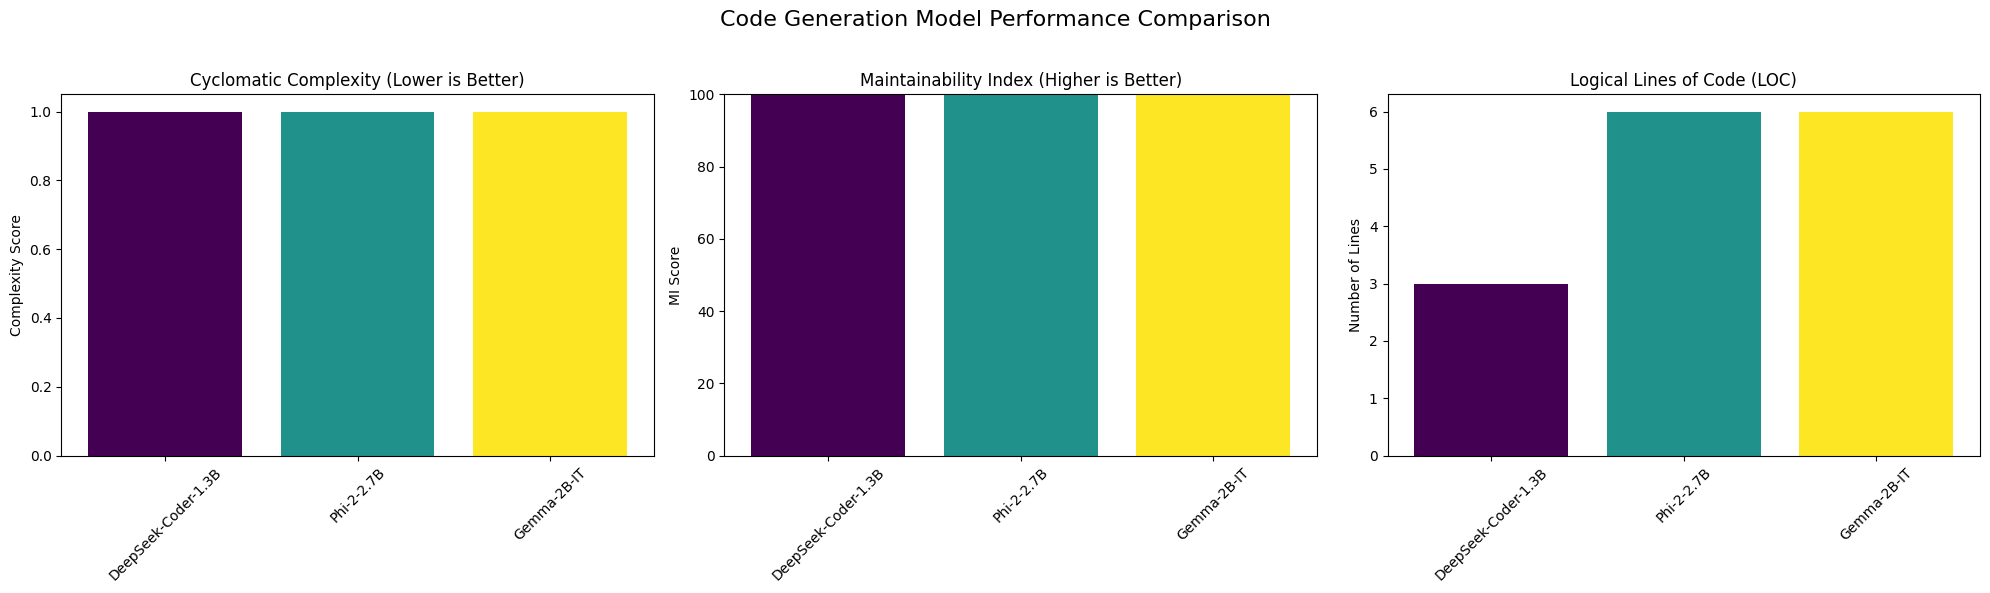

In [ ]:
# This UI allows you to select specific models to compare using checkboxes.

# --- UI Widgets ---
prompt_input_2 = widgets.Dropdown(
    options=SAMPLE_PROMPTS,
    description='Prompt:',
    style={'description_width': 'initial'},
    layout={'width': '95%'}
)
custom_prompt_input_2 = widgets.Textarea(
    placeholder='Or type your own custom prompt here...',
    layout={'width': '95%', 'height': '80px'}
)
# Dynamically create checkboxes based on the MODELS dictionary
model_checkboxes = [widgets.Checkbox(value=True, description=name) for name in MODELS.keys()]
checkbox_container = widgets.HBox(model_checkboxes)
inspect_button = widgets.Button(description="Generate & Inspect Selected", button_style='primary')
output_2 = widgets.Output()

# --- Event Handler ---
def on_inspect_button_clicked(b):
    with output_2:
        clear_output(wait=True)
        prompt = custom_prompt_input_2.value if custom_prompt_input_2.value else prompt_input_2.value
        if not prompt:
            print("🚨 Please select or enter a prompt.")
            return

        selected_models = [cb.description for cb in model_checkboxes if cb.value]
        if not selected_models:
            print("🚨 Please select at least one model to inspect.")
            return

        print(f"🚀 Starting inspection for prompt: '{prompt}'")
        print(f"Models selected: {', '.join(selected_models)}\n" + "="*52)
        results = {}
        for model_name in selected_models:
            print(f"--- Processing Model: {model_name} ---")
            model, tokenizer = load_model_and_tokenizer(model_name)
            if model is None: continue

            generated_code = generate_code(model, tokenizer, prompt)
            metrics = evaluate_code(generated_code)
            results[model_name] = {"code": generated_code, "metrics": metrics}

            print(f"\n✨ Generated Code:\n```python\n{generated_code}\n```")
            print(f"\n📊 Metrics: {metrics}")
            print("\n" + "-"*52 + "\n")

        print("📈 Generating performance plots...")
        plot_metrics(results)

inspect_button.on_click(on_inspect_button_clicked)

# --- Display UI ---
print("\n\nUI #2 is ready. Choose a prompt, select models, and click the button.")
display(prompt_input_2, custom_prompt_input_2, checkbox_container, inspect_button, output_2)